## **CNN for Character Classification**

Training dataset of mathematical characters is available at: https://www.kaggle.com/xainano/handwrittenmathsymbols

Around 500 pictures of each character (`0`, `1`, `2`, `3`, `4`, `5`, `6`, `7`, `8`, `9`, `+`, `-`, `×`, `(` and `)`) are given for the training of the convolutional neural network.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
import os
import cv2

In [ ]:
symbols_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', '(', ')', 'times']

### Reading data

In [ ]:
dataset_path = "/content/gdrive/MyDrive/Training_Dataset"
images = []
labels = []

for symbols_dir in os.listdir(dataset_path):
    if symbols_dir.split()[0] in symbols_list:
        for image in os.listdir(dataset_path + "/" + symbols_dir):
            labels.append(symbols_dir.split()[0])
            images.append(dataset_path + "/" + symbols_dir + "/" + image)

In [ ]:
print("Length of train_image : " , len(images) , " , length of labels list : " ,len(labels))

Length of train_image :  8199  , length of labels list :  8199


### Examples of images and their labels

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

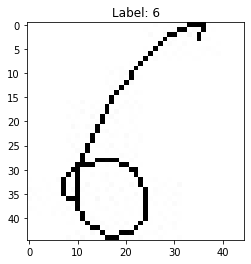

In [ ]:
image = cv2.imread(images[140])
plt.imshow(image)
plt.title("Label: " + labels[140])
plt.show()

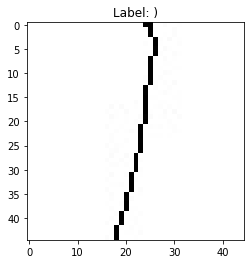

In [ ]:
image = cv2.imread(images[572])
plt.imshow(image)
plt.title("Label: " + labels[572])
plt.show()

### **Preprocessing data**

**Images as numpy arrays**

In [ ]:
X = []

for i in range(0,8199):
  img = cv2.imread(images[i])
  X.append(img)

In [ ]:
X = np.array(X)
X = X.astype('float32')
X /= 255
print(X.shape)

(8199, 45, 45, 3)


In [ ]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
y_temp = label_encoder.fit_transform(labels)

In [ ]:
print(y_temp.shape)

(8199,)


In [ ]:
import keras
from keras import utils as np_utils
y = keras.utils.np_utils.to_categorical(y_temp, 15)
print(y.shape)

(8199, 15)


In [ ]:
def character_detector(image):

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
  _,thresh = cv2.threshold(gray, 70, 255, cv2.THRESH_BINARY_INV) 
  kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
  dilated = cv2.dilate(thresh,kernel,iterations = 0) 
  contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

  cropped_images = np.zeros([len(contours), 45, 45]) 
  coordinates = np.zeros([len(contours), 2, 4])
  i = 0

  for contour in contours:
    [x,y,w,h] = cv2.boundingRect(contour)
    cropped_images[i,:,:] = cv2.resize(gray[y:y+h,x:x+w], dsize=(45, 45), interpolation=cv2.INTER_CUBIC)
    i = i + 1
  
  return cropped_images

In [ ]:
X.shape

(8199, 45, 45, 3)

In [ ]:
X_edited = np.zeros((8199,45,45))

for i in range(0, 8199):
  temp = character_detector(cv2.imread(images[i]))
  X_edited[i,:,:] = temp[0,:,:]

In [ ]:
X_edited.shape

(8199, 45, 45)

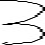

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(X_edited[3204,:,:])

In [ ]:
X_edited /= 255
X_edited[3204,:,:]

array([[0.        , 0.        , 0.00392157, ..., 0.99607843, 1.        ,
        1.        ],
       [1.        , 1.        , 0.99607843, ..., 0.99607843, 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.99607843, 0.99215686,
        0.99215686],
       ...,
       [1.        , 1.        , 1.        , ..., 0.99607843, 0.99215686,
        0.99215686],
       [1.        , 0.90588235, 0.40392157, ..., 0.99607843, 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X, y = unison_shuffled_copies(X_edited, y)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### CNN for Classification

In [ ]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), input_shape=(45,45,1), activation="relu"),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(15, activation="softmax")

])

model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.fit(X_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
205/205 [==============================] - 3s 8ms/step - loss: 1.1991 - accuracy: 0.6230
Epoch 2/5
205/205 [==============================] - 1s 7ms/step - loss: 0.4224 - accuracy: 0.8757
Epoch 3/5
205/205 [==============================] - 1s 7ms/step - loss: 0.2874 - accuracy: 0.9146
Epoch 4/5
205/205 [==============================] - 1s 7ms/step - loss: 0.2041 - accuracy: 0.9375
Epoch 5/5
205/205 [==============================] - 1s 7ms/step - loss: 0.1646 - accuracy: 0.9485


In [ ]:
model_1.predict(X_test)[15]

array([2.2935102e-12, 1.7774990e-14, 9.9982834e-01, 3.9745044e-11,
       7.8065066e-09, 7.7909226e-06, 1.4886914e-08, 8.2578781e-06,
       1.4420970e-04, 1.6097246e-07, 3.2880980e-08, 9.1002275e-06,
       1.6460863e-06, 4.1925529e-07, 2.8177963e-08], dtype=float32)

In [ ]:
model_1.evaluate(X_test, y_test)

52/52 [==============================] - 1s 5ms/step - loss: 0.2515 - accuracy: 0.9305


[0.2515210807323456, 0.9304878115653992]

In [ ]:
model_1.save("/content/gdrive/MyDrive/best_model_SavedModel_format")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/best_model_SavedModel_format/assets


In [ ]:
!cp /content/best_model_SavedModel_format /content/gdrive/MyDrive

cp: -r not specified; omitting directory '/content/best_model_SavedModel_format'
